# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [1]:
import pandas as pd
import geopandas as gp
import numpy as np
import urllib
import requests
import os
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.mixture import GMM as GaussianMixture
%matplotlib inline

In [2]:
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

In [3]:
if os.getenv("PUIDATA") is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
else:
    pass
print(os.getenv("PUIDATA"))

/nfshome/sg5718/PUIdata


In [5]:
!git clone https://github.com/fedhere/PUI2018_fb55
!unzip PUI2018_fb55/HW12_fb55/\*.zip -d $PUIDATA/HW12/cbbdata
!rm -rf PUI2018_fb55

Cloning into 'PUI2018_fb55'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 1290 (delta 22), reused 11 (delta 4), pack-reused 1249
Receiving objects: 100% (1290/1290), 67.92 MiB | 43.92 MiB/s, done.
Resolving deltas: 100% (571/571), done.
Checking connectivity... done.
Checking out files: 100% (266/266), done.
Archive:  PUI2018_fb55/HW12_fb55/zbp11totals.zip
  inflating: /nfshome/sg5718/PUIdata/HW12/cbbdata/zbp11totals.txt  

Archive:  PUI2018_fb55/HW12_fb55/zbp08totals.zip
  inflating: /nfshome/sg5718/PUIdata/HW12/cbbdata/zbp08totals.txt  

Archive:  PUI2018_fb55/HW12_fb55/zbp06totals.zip
  inflating: /nfshome/sg5718/PUIdata/HW12/cbbdata/zbp06totals.txt  

Archive:  PUI2018_fb55/HW12_fb55/zbp99totals.zip
  inflating: /nfshome/sg5718/PUIdata/HW12/cbbdata/zbp99totals.txt  

Archive:  PUI2018_fb55/HW12_fb55/zbp13totals.zip
  inflating: /nfshome/sg5718/PUIdata/HW12/cbbdata/zbp13totals.tx

In [4]:
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
!unzip application%2Fzip -d $PUIDATA/HW12/NYCzipcode
!rm -f application%2Fzip

--2018-12-11 22:24:36--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2018-12-11 22:24:36--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Reusing existing connection to data.cityofnewyork.us:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘application%2Fzip’

application%2Fzip       [    <=>             ]   1.44M  1.93MB/s    in 0.7s    

2018-12-11 22:24:37 (1.93 MB/s) - ‘application%2Fzip’ saved [1514401]

Archive:  applicati

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [4]:
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/HW12/NYCzipcode/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp                       
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [5]:
df = pd.read_csv((os.getenv("PUIDATA") + "/HW12/cbbdata/zbp11totals.txt"))
df.head()

,zip,name,empflag,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,city,stabbr,cty_name
0,501,"HOLTSVILLE, NY",A,D,0,D,0,D,0,2,HOLTSVILLE,NY,SUFFOLK
1,1001,"AGAWAM, MA",NaN,G,8788,G,75093,G,322008,436,AGAWAM,MA,HAMPDEN
2,1002,"AMHERST, MA",NaN,G,15878,G,84225,G,360685,558,AMHERST,MA,HAMPSHIRE
3,1003,"AMHERST, MA",NaN,G,198,H,2054,H,8591,16,AMHERST,MA,HAMPSHIRE
4,1004,"AMHERST, MA",C,S,0,H,1578,H,7063,19,AMHERST,MA,HAMPSHIRE


In [6]:
nyczipcode = pd.DataFrame(nyczips).sort_values(by=0).reset_index().drop('index', axis=1)
nyczipcode.rename(columns={0: "zip"},inplace=True)
nyczipcode.head()

,zip
0,83
1,10001
2,10002
3,10003
4,10004


In [7]:
## Get help on how to marge from Junru Lu (lj1230)
Years = [str(Year)[-2:] for Year in list(range(1994, 2015))]
for year in Years:
    cbbdata = pd.read_csv((os.getenv("PUIDATA") + "/HW12/cbbdata/zbp%stotals.txt"%year))
    if 'zip' in cbbdata.columns:
        nycbb = cbbdata[cbbdata.zip.isin(nyczips)]
        nyczipcode = nyczipcode.merge(nycbb[['zip', 'est']].rename(columns={'est': "est%s"%year}), how='left')
    elif 'ZIP' in cbbdata.columns:
        nycbb = cbbdata[cbbdata.ZIP.isin(nyczips)]
        nyczipcode = nyczipcode.merge(nycbb[['ZIP', 'EST']].rename(columns={'EST': "est%s"%year, 'ZIP': "zip"}), 
                              how='left')
nyczipcode.head()

,zip,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
2,10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
3,10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
4,10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0


In [8]:
# 20 years of data and 263 zipcodes
cbs = nyczipcode.iloc[:, 1:]
cbs.shape

(263, 21)

In [9]:
#cleaning all missing values
cleancsb = cbs.dropna()
cleancsb.shape

(243, 21)

In [10]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T
vals.head()

,est94,est95,est96,est97,est98,est99,est00,est01,est02,est03,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
1,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
2,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
3,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
4,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
5,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945


vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [11]:
vals.mean(axis=1).describe()

count    2.430000e+02
mean    -2.350690e-17
std      6.053129e-16
min     -2.421344e-15
25%     -2.749124e-16
50%     -1.057355e-17
75%      2.326182e-16
max      3.399397e-15
dtype: float64

In [12]:
vals.mean(axis=1).shape

(243,)

In [13]:
vals.std(axis=1).describe()

count    2.430000e+02
mean     1.000000e+00
std      1.004235e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [14]:
vals.std(axis=1).shape

(243,)

In [15]:
#cluster with kmeans
#Use Prof. Stanislav Sobolevsky's codes
from scipy.spatial.distance import cdist, pdist

def elbow(df_scaled,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(df_scaled) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(df_scaled, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/df_scaled.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(df_scaled)**2)/df_scaled.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

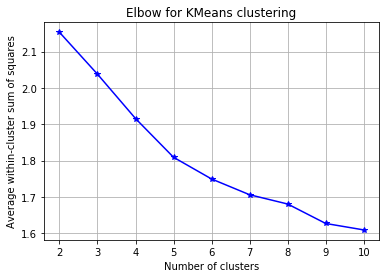

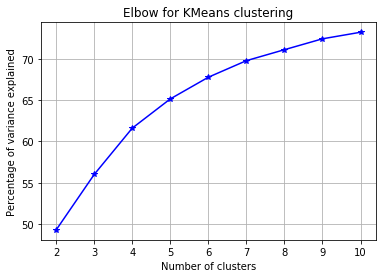

In [16]:
#Use the range K = [2, 10]
elbow(vals, range(2,11))

#### Figure 1: From the above plot, I may choose K=5.

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

for n_clusters in range(2, 11):
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(vals)
    #report average Silhouette score
    silhouette_avg = silhouette_score(vals, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.5721428017758581
For n_clusters =3, the average silhouette_score is :0.5377934557243654
For n_clusters =4, the average silhouette_score is :0.4956015504619568
For n_clusters =5, the average silhouette_score is :0.26600290597822634
For n_clusters =6, the average silhouette_score is :0.2747257901522158
For n_clusters =7, the average silhouette_score is :0.2327010110406102
For n_clusters =8, the average silhouette_score is :0.16236073442482432
For n_clusters =9, the average silhouette_score is :0.18790194121677045
For n_clusters =10, the average silhouette_score is :0.1715681929036577


#### From the result of silhouette_score, k=2 has the highest score. Therefore, I will chosse k = 2.

In [18]:
#cluster with kmeans
nc = 2
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [19]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(243,)

In [20]:
clusterzipk = nyczipcode.dropna()
clusterzipk['km'] = pd.DataFrame(km.predict(vals), index=clusterzipk.zip).reset_index()[[0]]
clusterzipk.iloc[:, 1:-1] = ((clusterzipk.iloc[:, 1:-1].T - clusterzipk.iloc[:, 1:-1].mean(1)) / 
                          clusterzipk.iloc[:, 1:-1].std(1)).T
clusterzipk.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered 

,zip,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est06,est07,est08,est09,est10,est11,est12,est13,est14,km
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,223.000000
mean,10697.687243,-1.009820,-0.900371,-0.804548,-0.651203,-0.560743,-0.463980,-0.349822,-0.327877,-0.180408,...,0.190658,0.277438,0.310202,0.360346,0.491133,0.569032,0.750864,0.949309,1.140232,0.188341
std,585.251017,1.116464,0.938837,0.812842,0.753154,0.775382,0.774400,0.799265,0.741319,0.553115,...,0.540521,0.542232,0.560468,0.587235,0.718749,0.842238,0.924538,1.000787,1.092847,0.391864
min,10001.000000,-3.459962,-2.367927,-1.897567,-1.892837,-2.054090,-1.821346,-2.105643,-1.666750,-1.841075,...,-1.910232,-1.559909,-1.435979,-1.696628,-1.649178,-2.113009,-2.020149,-1.827710,-2.019528,0.000000
25%,10121.500000,-1.645204,-1.470869,-1.319671,-1.090628,-1.002660,-0.929749,-0.831585,-0.760883,-0.463519,...,-0.011155,0.076569,0.087489,0.170918,0.282918,0.358136,0.477327,0.600566,0.778599,NaN
50%,10464.000000,-1.322172,-1.207515,-1.105014,-0.926456,-0.816361,-0.732544,-0.610926,-0.566623,-0.235929,...,0.223560,0.327569,0.409915,0.512900,0.744276,0.917255,1.165268,1.374920,1.613328,NaN
75%,11237.500000,-0.710121,-0.710477,-0.697991,-0.536456,-0.349955,-0.189823,-0.119517,-0.112660,-0.000853,...,0.513556,0.580074,0.636179,0.690089,0.948360,1.098092,1.375872,1.619954,1.844668,NaN
max,11697.000000,3.212291,2.228009,2.216083,1.698668,2.040039,2.143528,2.576381,2.705124,2.144307,...,1.397476,2.152288,1.781514,1.845008,1.505138,1.738911,2.405536,2.216690,3.406371,1.000000


In [21]:
clusterzipk.dropna(inplace=True)
clusterzipk.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,zip,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est06,est07,est08,est09,est10,est11,est12,est13,est14,km
1,10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0.0
2,10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0.0
3,10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,0.0
4,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0.0
5,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0.0


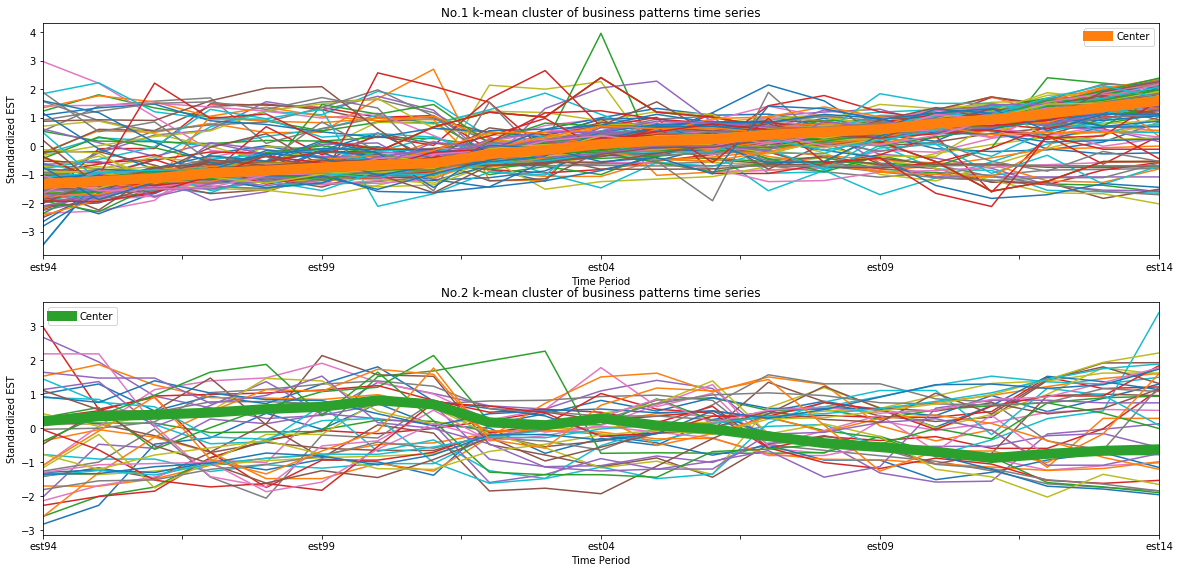

In [22]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(top=2.0)
for k in range(511, 513):
    ax = fig.add_subplot(k)
    ax.set_title("No.%s k-mean cluster of business patterns time series"%(int(str(k)[-1])))
    clusterk = clusterzipk[clusterzipk.km == int(str(k)[-1]) - 1].iloc[:, 1:-1]
    for i in range(clusterk.shape[0]):
        clusterk.iloc[i, :].plot(ax=ax, legend=False)
    pd.DataFrame(km.cluster_centers_[(int(str(k)[-1]) - 1)]).rename(columns={0: "Center"}).plot(ax=ax, 
                                                                                                legend=True, lw=10)
    ax.set_xlabel("Time Period")
    ax.set_ylabel("Standardized EST")

#### Figure 2: The business pattern time series are plotted above. No.1 cluster shows an increasing trend, while No.2 cluster shows a slightly decreasing trend. 

In [23]:
nyczipsshp = nyczipsshp[['ZIPCODE','geometry']]
nyczipsshp.shape

(263, 2)

In [24]:
clustermap = nyczipsshp[nyczipsshp.ZIPCODE.astype(int).isin(nyczipcode.zip.tolist())]
clustermap['ZIPCODE'] = clustermap['ZIPCODE'].astype('int')
clustermap.describe()

,ZIPCODE
count,263.000000
mean,10629.174905
std,874.151510
min,83.000000
25%,10113.500000
50%,10459.000000
75%,11234.500000
max,11697.000000


In [25]:
clusters = pd.DataFrame(km.predict(vals), index=nyczipcode.dropna().zip).reset_index()
clusters.describe()

,zip,0
count,243.000000,243.000000
mean,10697.687243,0.205761
std,585.251017,0.405091
min,10001.000000,0.000000
25%,10121.500000,0.000000
50%,10464.000000,0.000000
75%,11237.500000,0.000000
max,11697.000000,1.000000


In [26]:
kmclustermap = clustermap.merge(clusters, left_on='ZIPCODE', right_on='zip')
kmclustermap.head()

,ZIPCODE,geometry,zip,0
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


Text(0.5,1,'Kmeans Clustering Map')

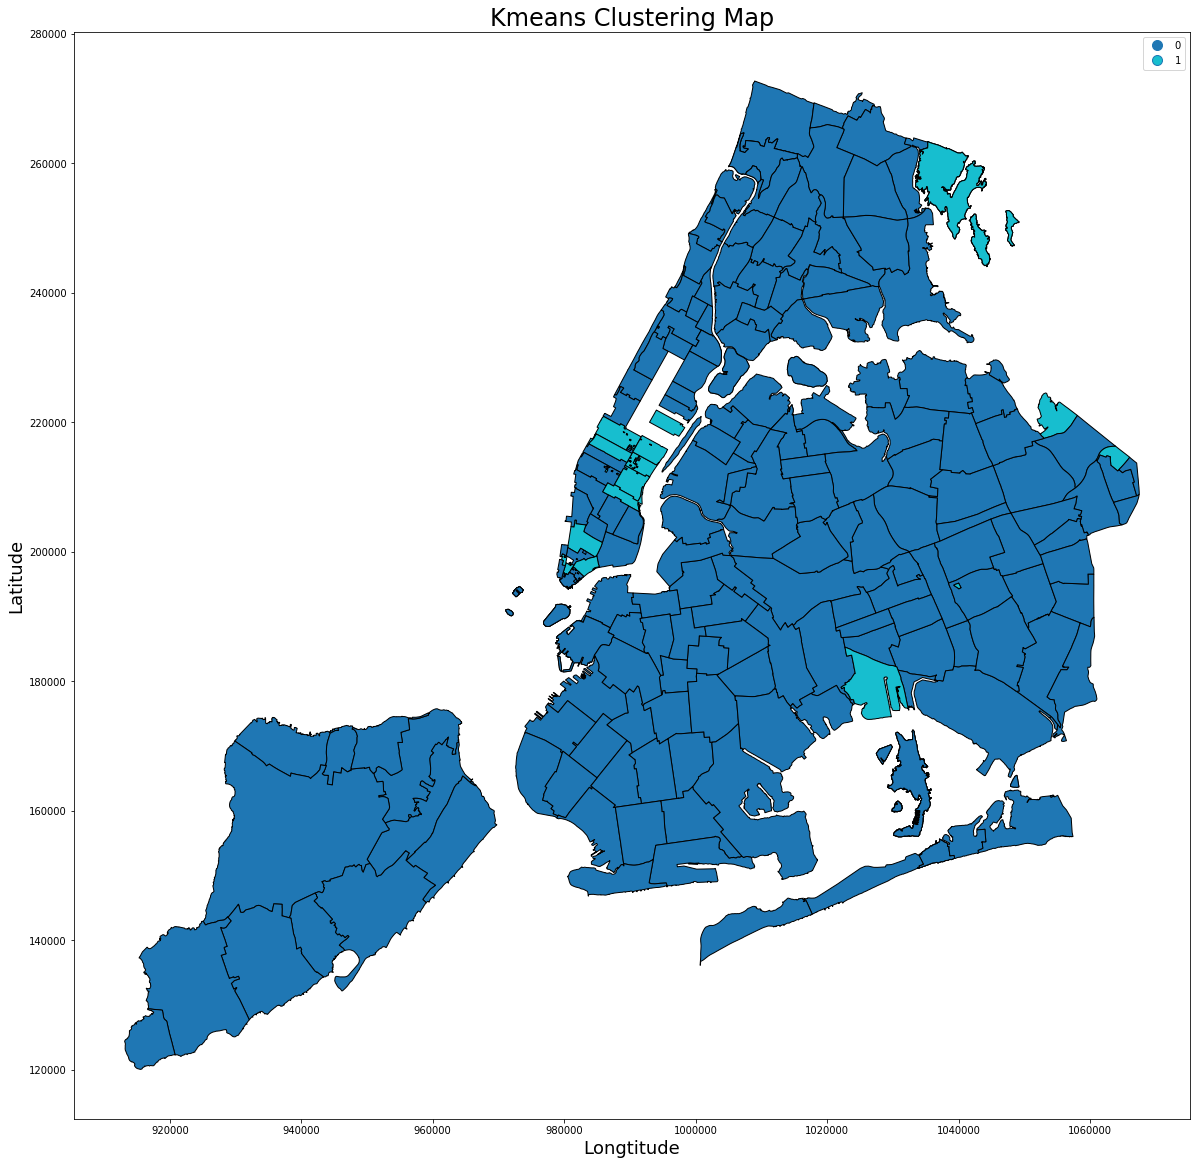

In [27]:
f = plt.figure(figsize=(20, 20))
ax = f.add_subplot(111)
kmclustermap.plot(column=0, categorical=True, legend=True, axes=ax, edgecolor="black")
ax.set_xlabel("Longtitude", fontsize=18)
ax.set_ylabel("Latitude", fontsize=18)
ax.set_title("Kmeans Clustering Map", fontsize=24)

#### Figure 3:  cloropleth of  cluster centers for 2 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. 

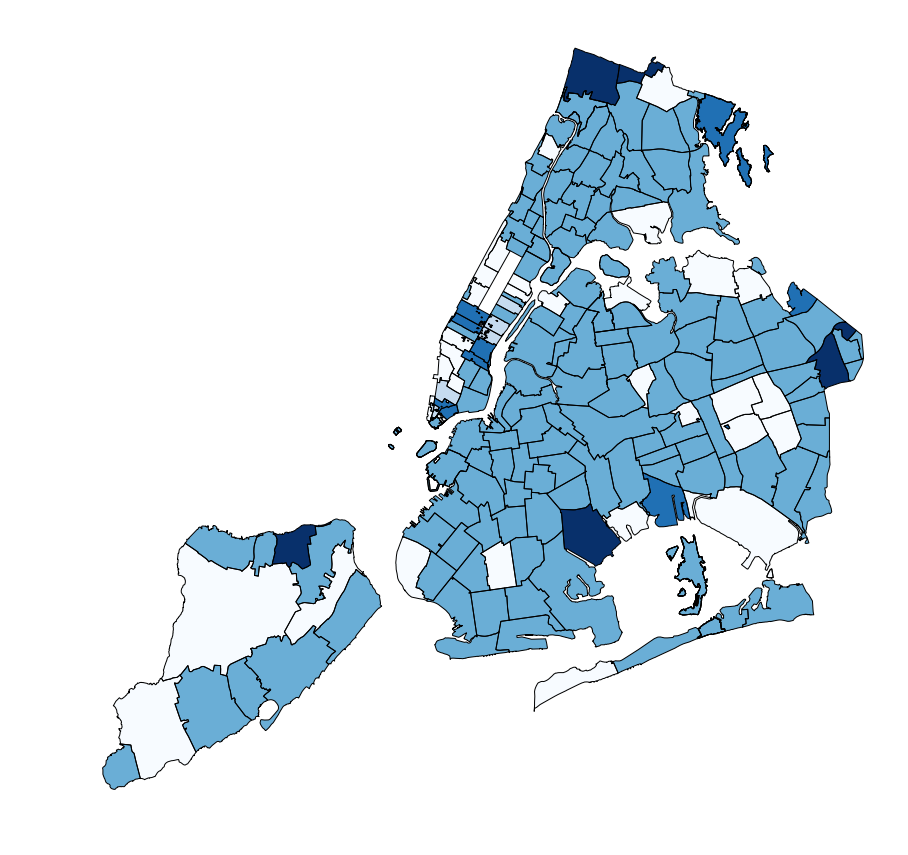

In [28]:
from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "K5.png")

#### The cloropleth with k = 5 looks better than the cloropleth with k = 2, even though k=2 has the highest silhouette_score.

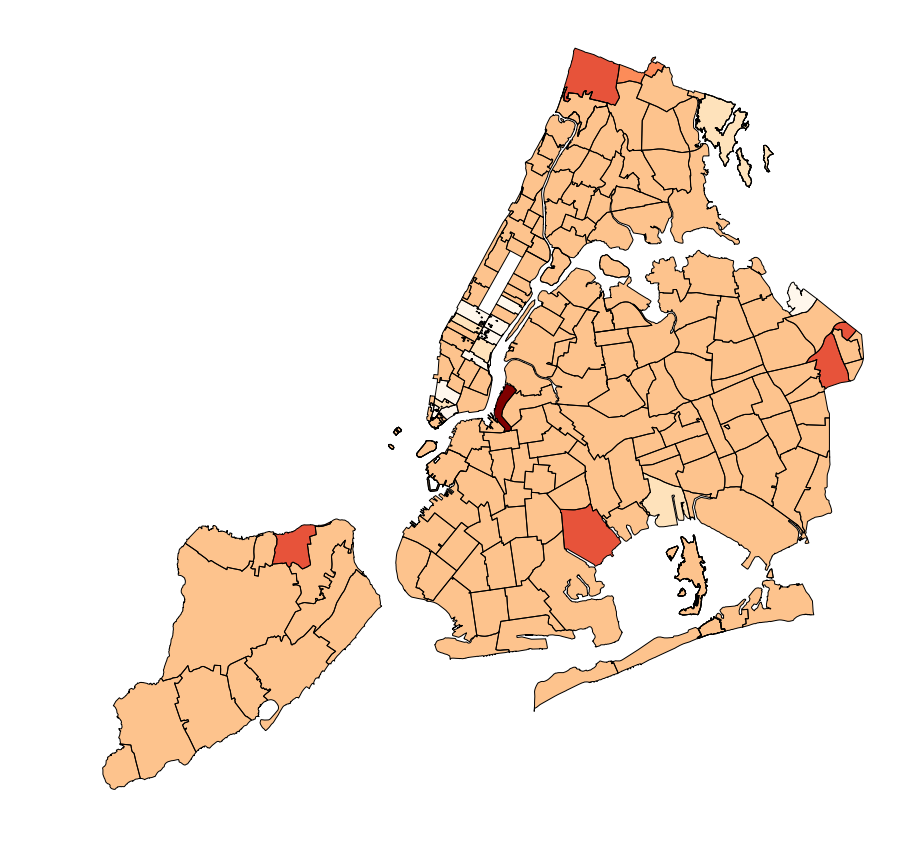

In [29]:
Image(filename = "K7.png")

#### We can see the pattern in the second cloropleth, whose k is 7, is similar to the cloropleth with k = 2. Therefore, it is unnecessary to have that many clusters.

# Agglomerative clustering

In [50]:
from sklearn.cluster import AgglomerativeClustering
 
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))

In [51]:
labelsag

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
clusterzipagg = nyczipcode.dropna()
clusterzipagg['agg'] = pd.DataFrame(labelsag, index=clusterzipagg.zip).reset_index()[[0]]
clusterzipagg.iloc[:, 1:-1] = ((clusterzipagg.iloc[:, 1:-1].T - clusterzipagg.iloc[:, 1:-1].mean(1)) / 
                          clusterzipagg.iloc[:, 1:-1].std(1)).T
clusterzipagg.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered 

,zip,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est06,est07,est08,est09,est10,est11,est12,est13,est14,agg
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,223.000000
mean,10697.687243,-1.009820,-0.900371,-0.804548,-0.651203,-0.560743,-0.463980,-0.349822,-0.327877,-0.180408,...,0.190658,0.277438,0.310202,0.360346,0.491133,0.569032,0.750864,0.949309,1.140232,0.139013
std,585.251017,1.116464,0.938837,0.812842,0.753154,0.775382,0.774400,0.799265,0.741319,0.553115,...,0.540521,0.542232,0.560468,0.587235,0.718749,0.842238,0.924538,1.000787,1.092847,0.346739
min,10001.000000,-3.459962,-2.367927,-1.897567,-1.892837,-2.054090,-1.821346,-2.105643,-1.666750,-1.841075,...,-1.910232,-1.559909,-1.435979,-1.696628,-1.649178,-2.113009,-2.020149,-1.827710,-2.019528,0.000000
25%,10121.500000,-1.645204,-1.470869,-1.319671,-1.090628,-1.002660,-0.929749,-0.831585,-0.760883,-0.463519,...,-0.011155,0.076569,0.087489,0.170918,0.282918,0.358136,0.477327,0.600566,0.778599,NaN
50%,10464.000000,-1.322172,-1.207515,-1.105014,-0.926456,-0.816361,-0.732544,-0.610926,-0.566623,-0.235929,...,0.223560,0.327569,0.409915,0.512900,0.744276,0.917255,1.165268,1.374920,1.613328,NaN
75%,11237.500000,-0.710121,-0.710477,-0.697991,-0.536456,-0.349955,-0.189823,-0.119517,-0.112660,-0.000853,...,0.513556,0.580074,0.636179,0.690089,0.948360,1.098092,1.375872,1.619954,1.844668,NaN
max,11697.000000,3.212291,2.228009,2.216083,1.698668,2.040039,2.143528,2.576381,2.705124,2.144307,...,1.397476,2.152288,1.781514,1.845008,1.505138,1.738911,2.405536,2.216690,3.406371,1.000000


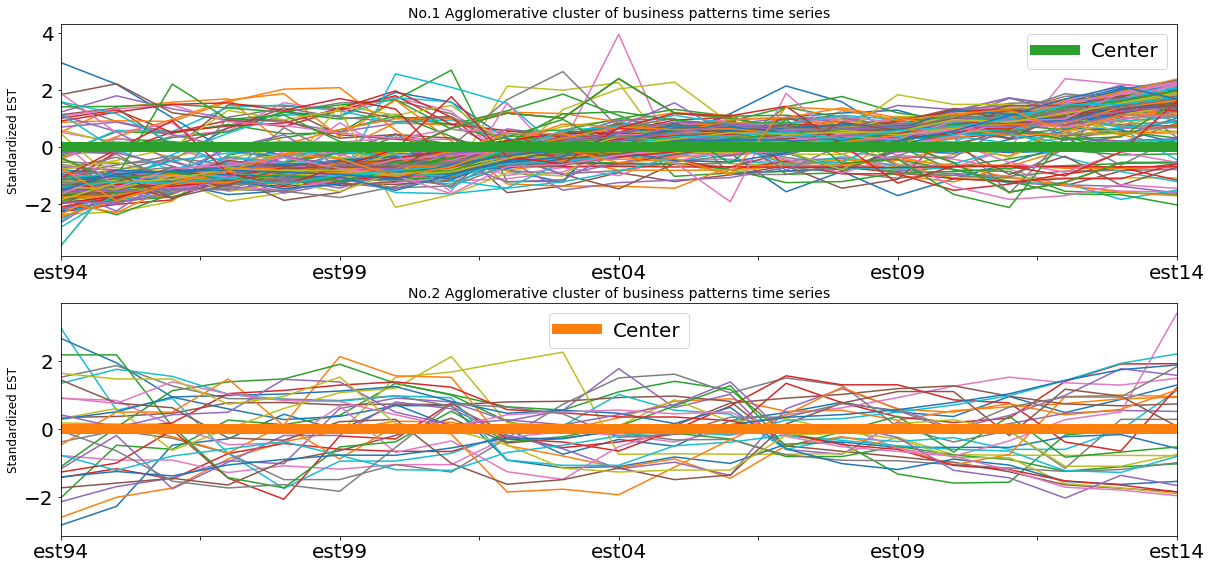

In [57]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(top=2.0)
for a in range(511, 513):
    ax = fig.add_subplot(a)
    ax.set_title("No.%s Agglomerative cluster of business patterns time series"%(int(str(a)[-1])),fontsize=14)
    clusteragg = clusterzipagg[clusterzipagg.agg == int(str(a)[-1]) - 1].iloc[:, 1:-1]
    for i in range(clusteragg.shape[0]):
        clusteragg.iloc[i, :].plot(ax=ax, legend=False)
    pd.DataFrame(centroidsag[(int(str(a)[-1]) - 1)]).rename(columns={0: "Center"}).plot(ax=ax, 
                                                                                                legend=True, lw=10)
    ax.set_ylabel("Standardized EST",fontsize=12)

#### Figure 4:  The business pattern time series are plotted above. 

In [34]:
aggclusters = pd.DataFrame(labelsag, index=nyczipcode.dropna().zip).reset_index()
aggclusters.describe()

,zip,0
count,243.000000,243.000000
mean,10697.687243,0.152263
std,585.251017,0.360018
min,10001.000000,0.000000
25%,10121.500000,0.000000
50%,10464.000000,0.000000
75%,11237.500000,0.000000
max,11697.000000,1.000000


In [35]:
aggclustermap = clustermap.merge(aggclusters, left_on='ZIPCODE', right_on='zip')
aggclustermap.head()

,ZIPCODE,geometry,zip,0
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


Text(0.5,1,' Agglomerative Clustering Map')

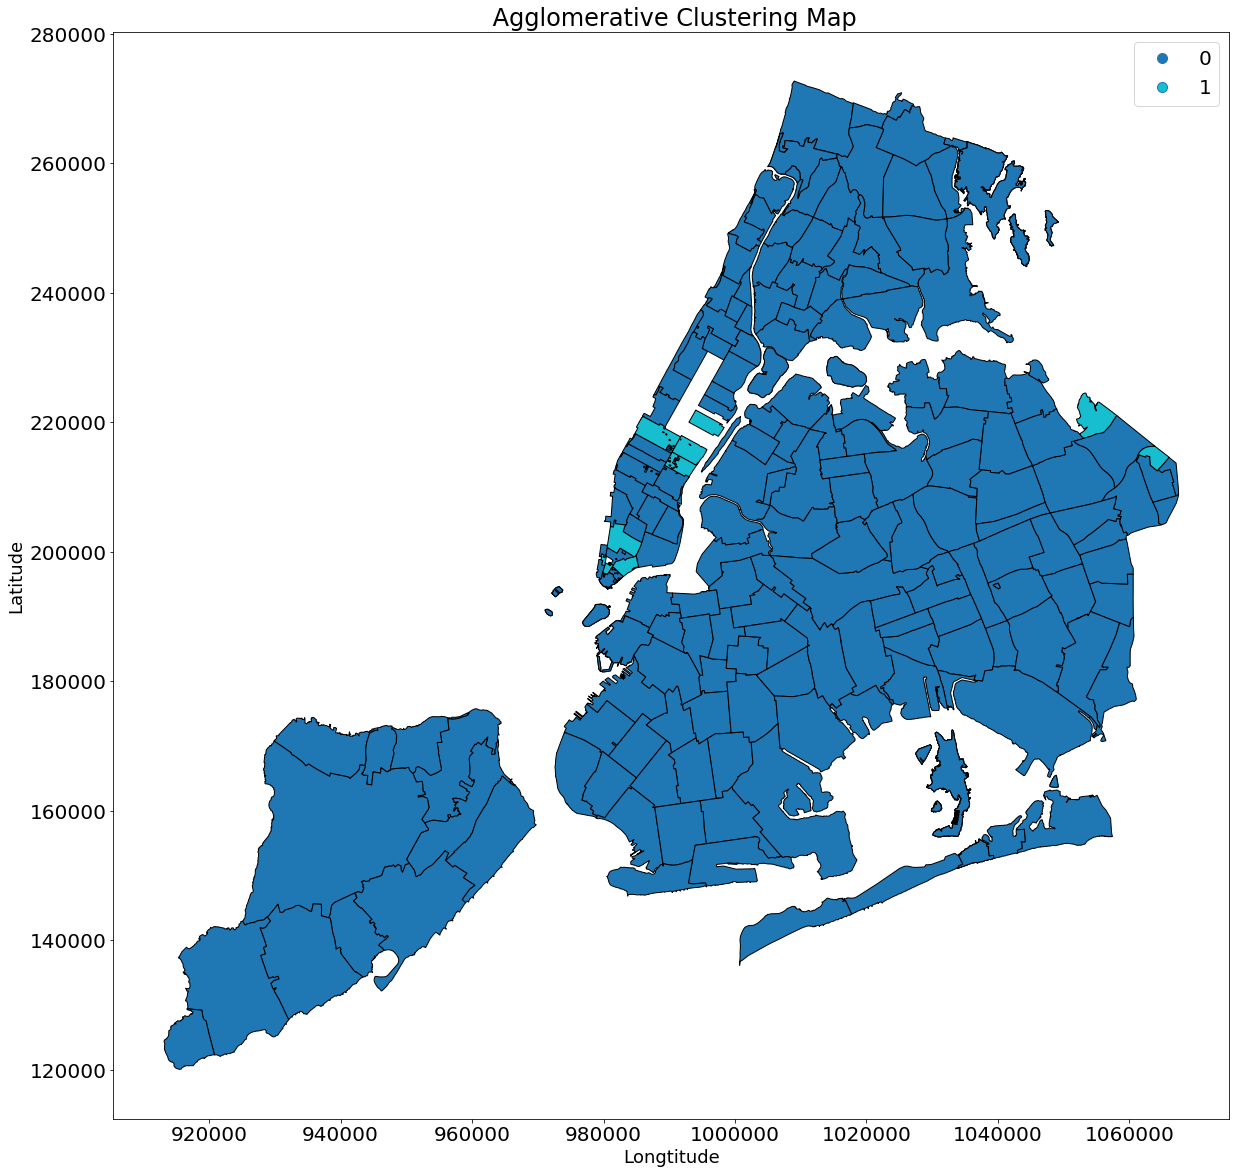

In [36]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
aggclustermap.plot(column=0, categorical=True, legend=True, axes=ax, edgecolor="black")
ax.set_xlabel("Longtitude", fontsize=18)
ax.set_ylabel("Latitude", fontsize=18)
ax.set_title(" Agglomerative Clustering Map", fontsize=24)

#### Figure 4: Cloropleth of cluster centers for 2 Agglomerative clusters. K-means seems do better.

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

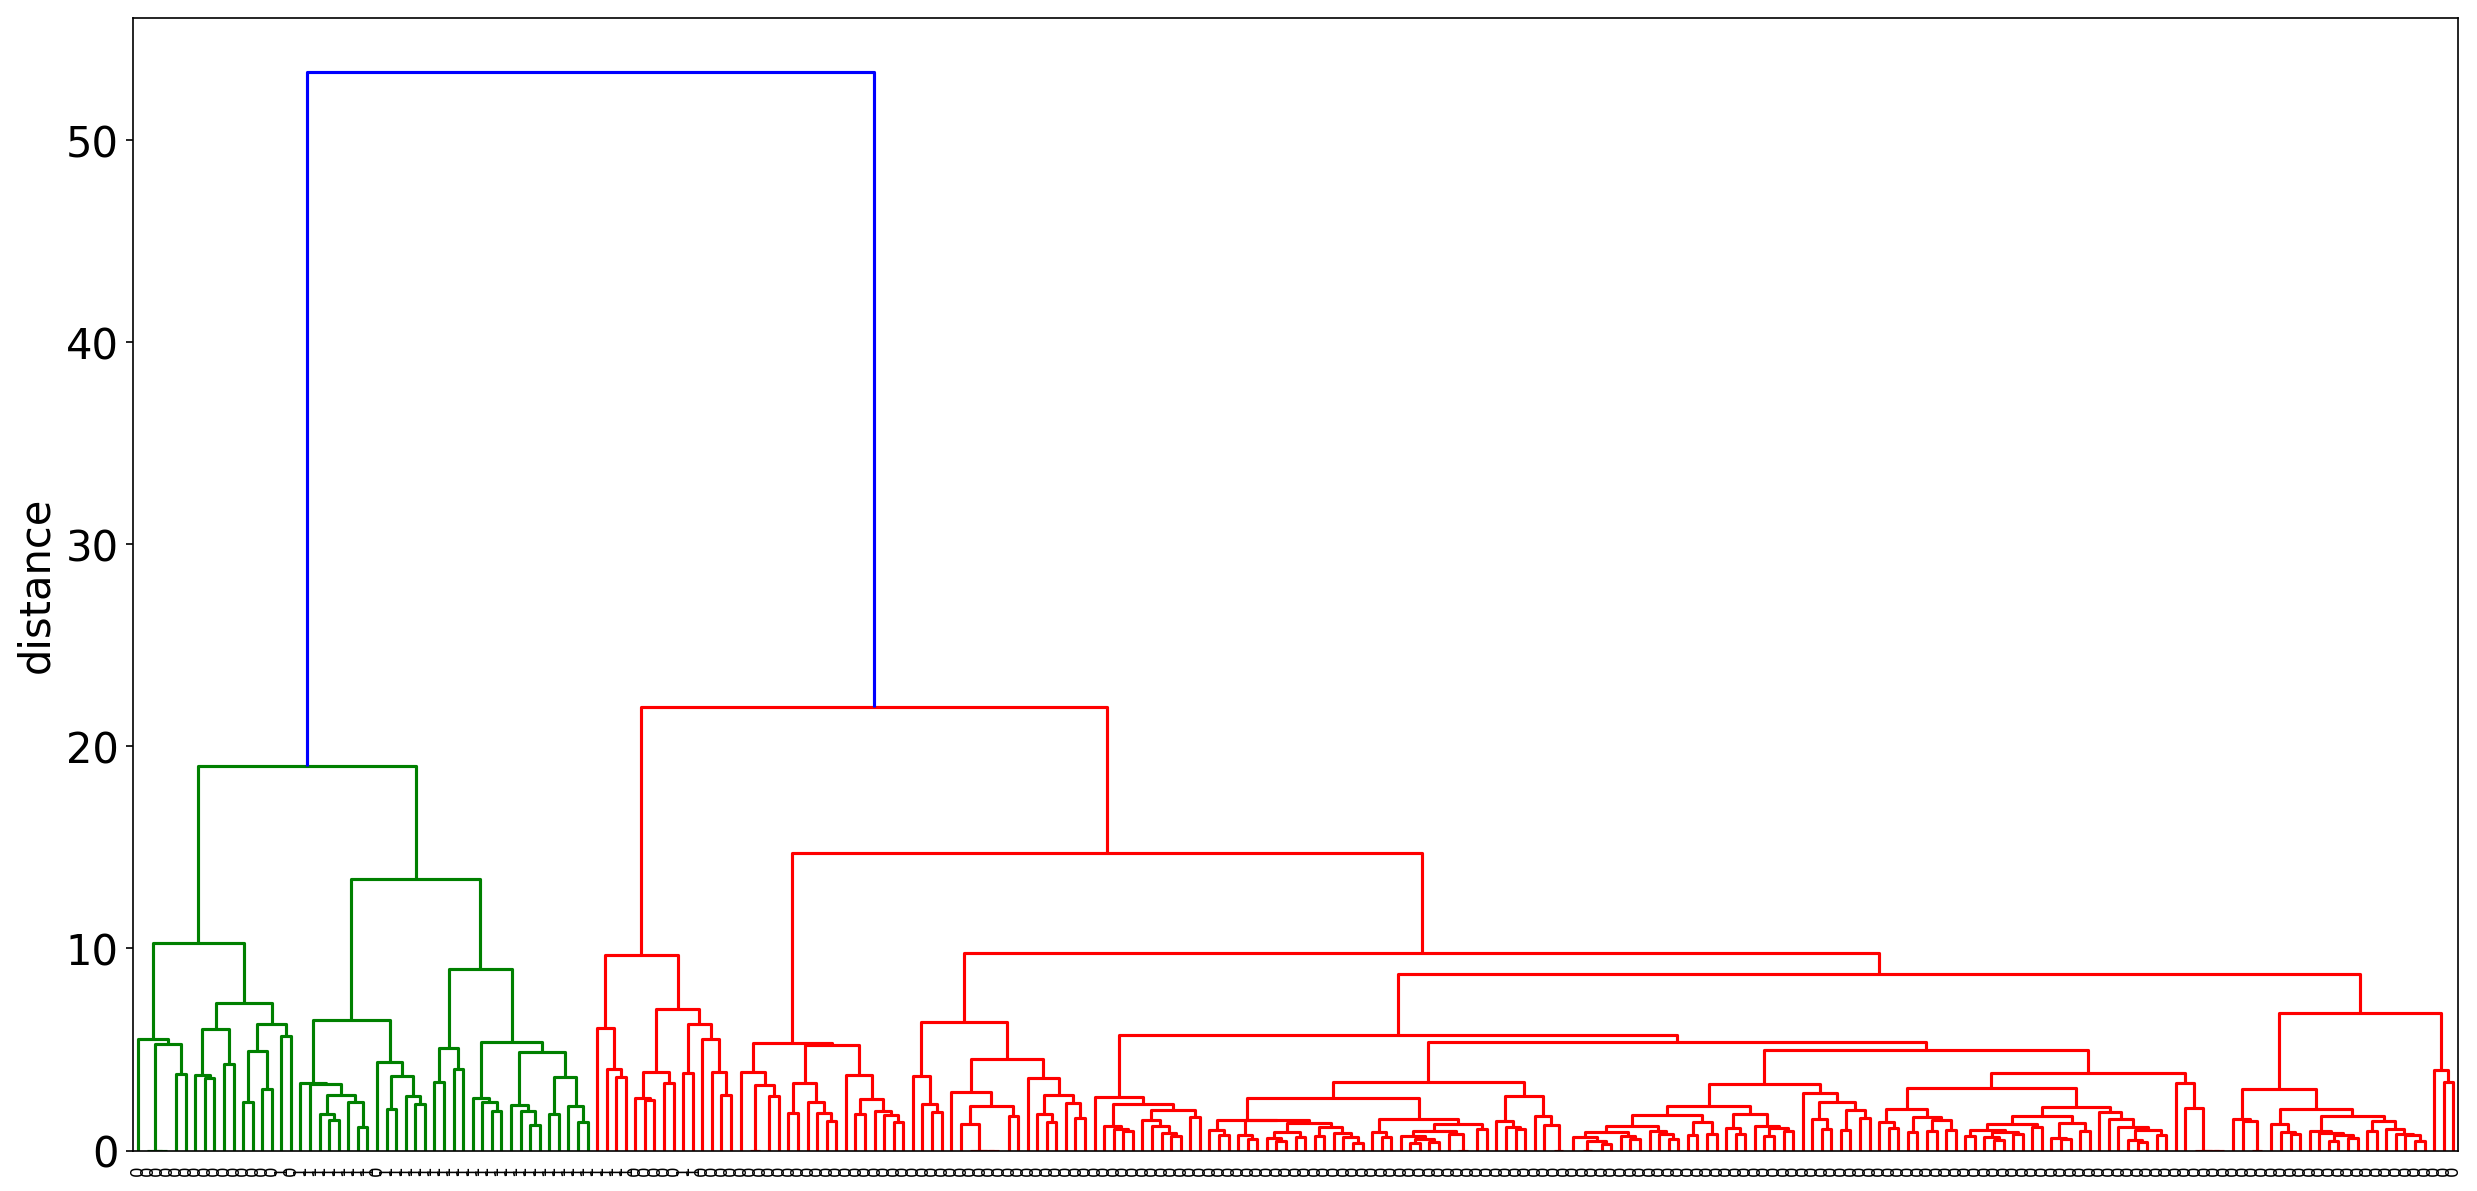

In [37]:
import scipy.cluster as scp
fig = pl.figure(figsize=(20,10), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'), labels = labelsag,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels

#### I am really not sure whether I used agglomerative clustering correctly. Therefore, I choose the third way.

# Gaussian Mixture learned in ADS Class

In [38]:
from sklearn.mixture import GMM
k = 2
dd = vals
gm = GMM(n_components=2,random_state=324)
res1=gm.fit(dd)
resG = res1.predict(dd)
resG

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1])

In [39]:
clusterzipgm = nyczipcode.dropna()
clusterzipgm['gm'] = pd.DataFrame(resG, index=clusterzipgm.zip).reset_index()[[0]]
clusterzipgm.iloc[:, 1:-1] = ((clusterzipgm.iloc[:, 1:-1].T - clusterzipgm.iloc[:, 1:-1].mean(1)) / 
                          clusterzipgm.iloc[:, 1:-1].std(1)).T
clusterzipgm.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered 

,zip,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est06,est07,est08,est09,est10,est11,est12,est13,est14,gm
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,223.000000
mean,10697.687243,-1.009820,-0.900371,-0.804548,-0.651203,-0.560743,-0.463980,-0.349822,-0.327877,-0.180408,...,0.190658,0.277438,0.310202,0.360346,0.491133,0.569032,0.750864,0.949309,1.140232,0.358744
std,585.251017,1.116464,0.938837,0.812842,0.753154,0.775382,0.774400,0.799265,0.741319,0.553115,...,0.540521,0.542232,0.560468,0.587235,0.718749,0.842238,0.924538,1.000787,1.092847,0.480711
min,10001.000000,-3.459962,-2.367927,-1.897567,-1.892837,-2.054090,-1.821346,-2.105643,-1.666750,-1.841075,...,-1.910232,-1.559909,-1.435979,-1.696628,-1.649178,-2.113009,-2.020149,-1.827710,-2.019528,0.000000
25%,10121.500000,-1.645204,-1.470869,-1.319671,-1.090628,-1.002660,-0.929749,-0.831585,-0.760883,-0.463519,...,-0.011155,0.076569,0.087489,0.170918,0.282918,0.358136,0.477327,0.600566,0.778599,NaN
50%,10464.000000,-1.322172,-1.207515,-1.105014,-0.926456,-0.816361,-0.732544,-0.610926,-0.566623,-0.235929,...,0.223560,0.327569,0.409915,0.512900,0.744276,0.917255,1.165268,1.374920,1.613328,NaN
75%,11237.500000,-0.710121,-0.710477,-0.697991,-0.536456,-0.349955,-0.189823,-0.119517,-0.112660,-0.000853,...,0.513556,0.580074,0.636179,0.690089,0.948360,1.098092,1.375872,1.619954,1.844668,NaN
max,11697.000000,3.212291,2.228009,2.216083,1.698668,2.040039,2.143528,2.576381,2.705124,2.144307,...,1.397476,2.152288,1.781514,1.845008,1.505138,1.738911,2.405536,2.216690,3.406371,1.000000


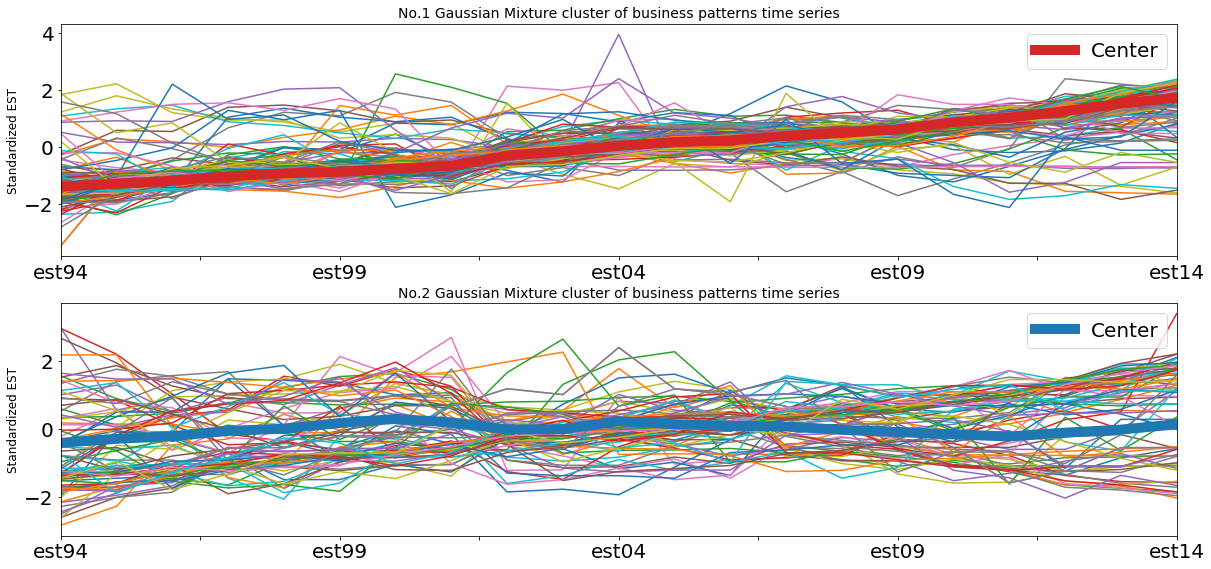

In [45]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(top=2.0)
for g in range(511, 513):
    ax = fig.add_subplot(g)
    ax.set_title("No.%s Gaussian Mixture cluster of business patterns time series"%(int(str(g)[-1])),fontsize=14)
    clusterg = clusterzipgm[clusterzipgm.gm == int(str(g)[-1]) - 1].iloc[:, 1:-1]
    for i in range(clusterg.shape[0]):
        clusterg.iloc[i, :].plot(ax=ax, legend=False)
    pd.DataFrame(gm.means_[(int(str(g)[-1]) - 1)]).rename(columns={0: "Center"}).plot(ax=ax,
                                                                                      legend=True,lw=10)
    ax.set_ylabel("Standardized EST",fontsize=12)

#### Figure 5: The business pattern time series are plotted above. No.1 cluster shows an increasing trend, while No.2 cluster floats up or down slightly and shows no obvious trend.

In [41]:
gmclusters = pd.DataFrame(resG, index=nyczipcode.dropna().zip).reset_index()
gmclusters.describe()

,zip,0
count,243.000000,243.000000
mean,10697.687243,0.378601
std,585.251017,0.486040
min,10001.000000,0.000000
25%,10121.500000,0.000000
50%,10464.000000,0.000000
75%,11237.500000,1.000000
max,11697.000000,1.000000


In [42]:
gmclustermap = clustermap.merge(gmclusters, left_on='ZIPCODE', right_on='zip')
gmclustermap.head()

,ZIPCODE,geometry,zip,0
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


Text(0.5,1,'Gaussian Mixture Clustering Map')

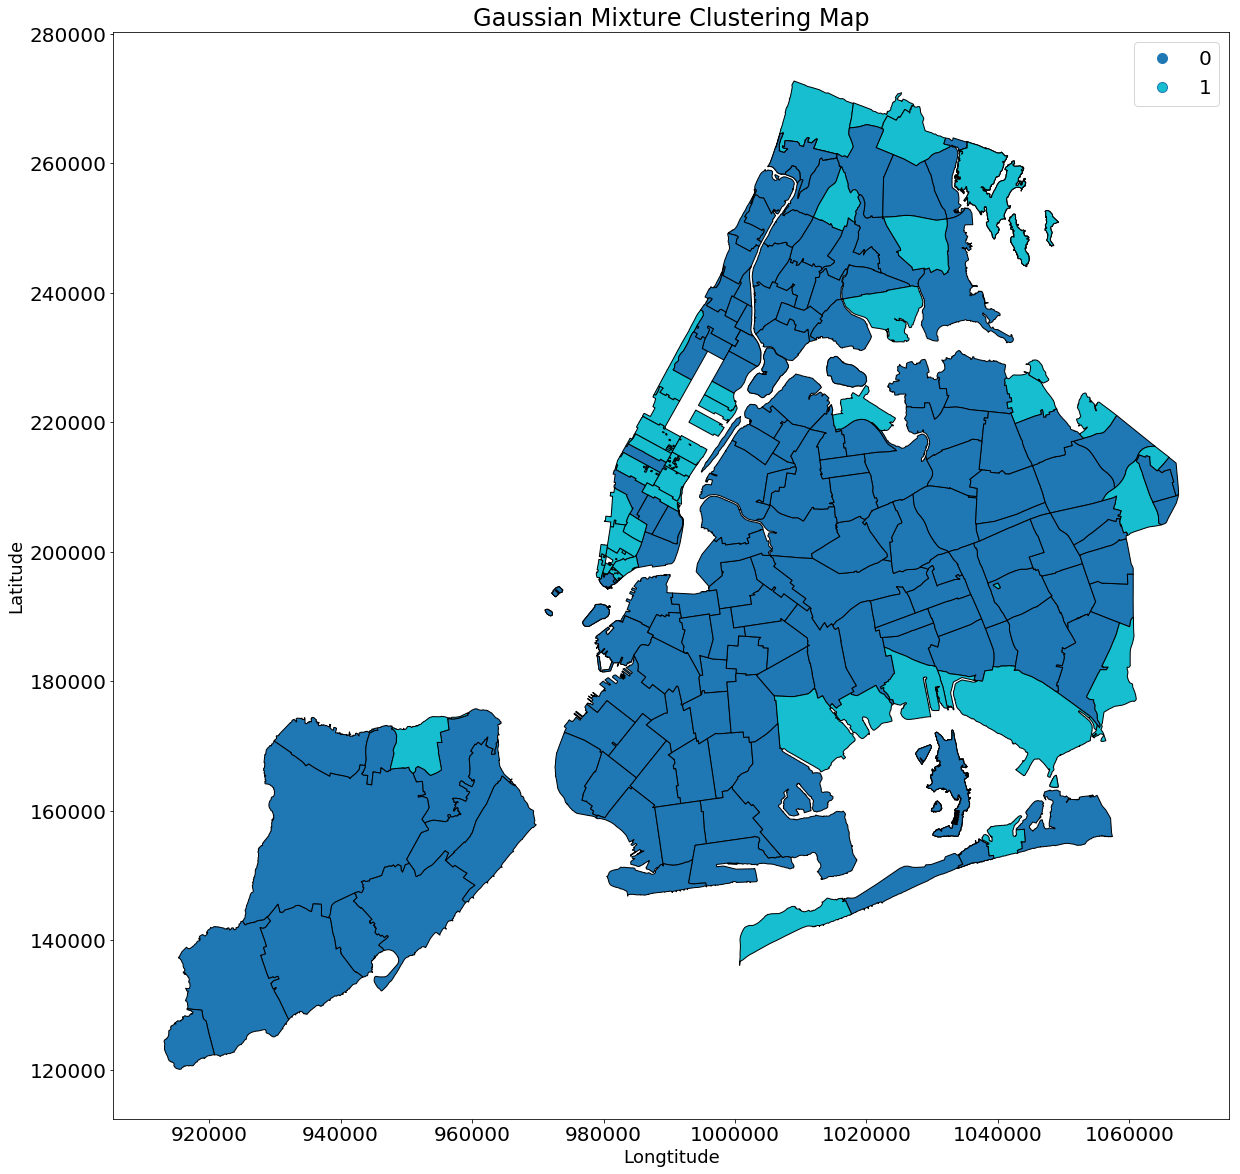

In [43]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
gmclustermap.plot(column=0, categorical=True, legend=True, axes=ax, edgecolor="black")
ax.set_xlabel("Longtitude", fontsize=18)
ax.set_ylabel("Latitude", fontsize=18)
ax.set_title("Gaussian Mixture Clustering Map", fontsize=24)

#### Figure 6: Cloropleth of cluster centers for 2 Gaussian Mixture clusters, which looks better than K-means. The two partitions become more definite.